In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip -q install xarray netCDF4 dask[complete] pandas numpy matplotlib tqdm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, zipfile

# Paths
ZIP = "/content/drive/MyDrive/ClimateProject/NORESM2_LM_full.zip"
BASE = "/tmp/NORESM2_LM_full"

# Make sure extraction folder exists
os.makedirs(BASE, exist_ok=True)

# Extract zip
print(f"Extracting: {ZIP} → {BASE}")
with zipfile.ZipFile(ZIP, 'r') as z:
    z.extractall(BASE)

print("✅ Extraction complete.")

# Verify top-level structure
for root, dirs, files in os.walk(BASE):
    print("📂", root)
    for d in dirs[:5]:
        print("   ├──", d)
    for f in files[:5]:
        print("   └──", f)
    print("-----")
    # stop early so it doesn't flood output
    if "historical" in root or "ssp" in root:
        break


Extracting: /content/drive/MyDrive/ClimateProject/NORESM2_LM_full.zip → /tmp/NORESM2_LM_full
✅ Extraction complete.
📂 /tmp/NORESM2_LM_full
   └── input4mips_ssp126_BC_sum_250_km_mon_2033_input4mips_ssp126_BC_anthro-fires_sum_250_km_mon_gn_2033.nc
   └── input4mips\ssp245\CH4_sum\250_km\mon\2060\input4mips_ssp245_CH4_all-fires_sum_250_km_mon_gn_2060.nc
   └── NorESM2-LM_r1i1p1f1_ssp126_pr_250_km_mon_2090_CMIP6_NorESM2-LM_r1i1p1f1_ssp126_pr_250_km_mon_gn_2090.nc
   └── NorESM2-LM\r1i1p1f1\historical\tas\250_km\mon\1997\CMIP6_NorESM2-LM_r1i1p1f1_historical_tas_250_km_mon_gn_1997.nc
   └── input4mips\historical\BC_sum\250_km\mon\1971\input4mips_historical_BC_anthro-fires_sum_250_km_mon_gn_1971.nc
-----


In [ ]:
import os, shutil

BASE = "/tmp/NORESM2_LM_full"
fixed_dirs, fixed_files = 0, 0

for root, dirs, files in os.walk(BASE, topdown=False):
    for name in files:
        if "\\" in name:
            new_name = name.replace("\\", "_")
            os.rename(os.path.join(root, name), os.path.join(root, new_name))
            fixed_files += 1
    for name in dirs:
        if "\\" in name:
            new_name = name.replace("\\", "_")
            old_path = os.path.join(root, name)
            new_path = os.path.join(root, new_name)
            # Move the directory if needed
            if not os.path.exists(new_path):
                os.rename(old_path, new_path)
            fixed_dirs += 1

print(f"✅ Fixed {fixed_dirs} directories and {fixed_files} files containing backslashes.")


✅ Fixed 0 directories and 7343 files containing backslashes.


In [ ]:
import glob

BASE = "/tmp/NORESM2_LM_full"

print("Sample .nc files after cleanup:\n")
for f in glob.glob(f"{BASE}/**/*.nc", recursive=True)[:10]:
    print("  ", f)


Sample .nc files after cleanup:

   /tmp/NORESM2_LM_full/input4mips_ssp126_BC_sum_250_km_mon_2033_input4mips_ssp126_BC_anthro-fires_sum_250_km_mon_gn_2033.nc
   /tmp/NORESM2_LM_full/NorESM2-LM_r1i1p1f1_ssp126_pr_250_km_mon_2090_CMIP6_NorESM2-LM_r1i1p1f1_ssp126_pr_250_km_mon_gn_2090.nc
   /tmp/NORESM2_LM_full/input4mips_ssp370_CO2_sum_250_km_mon_2079_input4mips_ssp370_CO2_sum_250_km_mon_gn_2079.nc
   /tmp/NORESM2_LM_full/input4mips_historical_CH4_sum_250_km_mon_2007_input4mips_historical_CH4_all-fires_sum_250_km_mon_gn_2007.nc
   /tmp/NORESM2_LM_full/input4mips_ssp245_BC_sum_250_km_mon_2062_input4mips_ssp245_BC_no-fires_sum_250_km_mon_gn_2062.nc
   /tmp/NORESM2_LM_full/NorESM2-LM_r3i1p1f1_ssp245_tas_250_km_mon_2038_CMIP6_NorESM2-LM_r3i1p1f1_ssp245_tas_250_km_mon_gn_2038.nc
   /tmp/NORESM2_LM_full/input4mips_historical_SO2_sum_250_km_mon_1957_input4mips_historical_SO2_all-fires_sum_250_km_mon_gn_1957.nc
   /tmp/NORESM2_LM_full/input4mips_ssp585_CO2_sum_250_km_mon_2061_input4mips_ssp585_C

In [ ]:
import xarray as xr
import numpy as np
import glob
import pandas as pd

BASE = "/tmp/NORESM2_LM_full"
print("✅ Base folder set:", BASE)


✅ Base folder set: /tmp/NORESM2_LM_full


In [ ]:
# Function to select all files for a given scenario + variable
def select_files(scenario, var):
    files = sorted([
        f for f in glob.glob(f"{BASE}/**/*.nc", recursive=True)
        if scenario in f.lower() and var.lower() in f.lower()
    ])
    print(f"{var}: {len(files)} files")
    return files


In [ ]:
vars_in = ["CO2", "CH4", "SO2", "BC"]
inputs = {}

for v in vars_in:
    files = select_files("historical", v)
    if not files:
        print(f"⚠️ No files found for {v}")
        continue
    ds = xr.open_mfdataset(files, combine="by_coords", parallel=False, decode_times=False)
    vname = list(ds.data_vars)[0]
    inputs[v] = ds[vname]
print("✅ Loaded all input variables.")

CO2: 265 files
CH4: 495 files
SO2: 795 files
BC: 795 files
✅ Loaded all input variables.


In [ ]:
tas_files = select_files("historical", "tas")
pr_files  = select_files("historical", "pr")

tas = xr.open_mfdataset(tas_files, combine="by_coords", decode_times=False)["tas"]
pr  = xr.open_mfdataset(pr_files, combine="by_coords", decode_times=False)["pr"]

# Convert units
tas = tas - 273.15
tas.attrs["units"] = "degC"
pr = pr * 86400
pr.attrs["units"] = "mm/day"

print("✅ tas & pr loaded and units converted.")


tas: 165 files
pr: 65 files
✅ tas & pr loaded and units converted.


In [ ]:
def fix_time(ds, start_year=1850):
    ds = ds.compute() if hasattr(ds, "compute") else ds
    if "time" in ds.coords:
        ntime = len(ds["time"])
        ds["time"] = pd.date_range(f"{start_year}-01-01", periods=ntime, freq="MS")
    return ds

tas = fix_time(tas)
pr  = fix_time(pr)
for k in inputs:
    inputs[k] = fix_time(inputs[k])

print("✅ Time fixed for all datasets.")


✅ Time fixed for all datasets.


In [ ]:
lat, lon = tas.lat, tas.lon

# Align inputs with tas grid & time using interpolation
for k in inputs:
    inputs[k] = inputs[k].interp_like(tas)

# Align pr with tas as well
pr = pr.interp_like(tas)

print("✅ All variables aligned to tas grid & time.")


✅ All variables aligned to tas grid & time.


In [ ]:
ds_hist = xr.Dataset(
    {
        "CO2": inputs["CO2"],
        "CH4": inputs["CH4"],
        "SO2": inputs["SO2"],
        "BC":  inputs["BC"],
        "Temperature": tas,
        "Precipitation": pr,
    }
)

ds_hist.attrs = {
    "source_model": "NorESM2-LM",
    "scenario": "historical",
    "years": "1850–2014",
    "inputs": "CO2,CH4,SO2,BC",
    "outputs": "Temperature,Precipitation",
    "spatial_res": "≈250 km",
    "temporal_res": "monthly",
    "created_by": "Richee"
}

print("✅ Combined dataset created.")
print(ds_hist)


✅ Combined dataset created.
<xarray.Dataset> Size: 1GB
Dimensions:        (lon: 144, lat: 96, time: 1980, x: 144, y: 96)
Coordinates:
  * lon            (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * lat            (lat) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * time           (time) datetime64[ns] 16kB 1850-01-01 ... 2014-12-01
  * x              (x) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * y              (y) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
Data variables:
    CO2            (time, lat, lon) float64 219MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    CH4            (time, lat, lon) float64 219MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SO2            (time, lat, lon) float64 219MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    BC             (time, lat, lon) float64 219MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Temperature    (time, y, x) float32 109MB -27.99 -28.11 ... -20.65 -20.65
    Precipitation  (time, y, x) float64 219MB 0.0459 0.0459 0.04591 ... 

In [ ]:
import pandas as pd

# Convert the xarray Dataset to a pandas DataFrame
# This will flatten the 'time', 'lat', and 'lon' dimensions into the index
df_hist = ds_hist.to_dataframe()

# Define the path to save the CSV file in your Google Drive
csv_save_path = "/content/drive/MyDrive/ClimateProject/NORESM2_LM_historical_4in2out.csv"

# Save the DataFrame to a CSV file
df_hist.to_csv(csv_save_path)

print(f"✅ Historical dataset saved to CSV: {csv_save_path}")

In [ ]:
# ✅ Safe one-cell fix for both "Permission denied" & "HDF error"

from google.colab import drive
import os
import xarray as xr

# 1️⃣ Mount Google Drive freshly
drive.mount('/content/drive', force_remount=True)

# 2️⃣ Create save directory
save_dir = "/content/drive/MyDrive/ClimateProject"
os.makedirs(save_dir, exist_ok=True)

# 3️⃣ Define path
save_path = os.path.join(save_dir, "NORESM2_LM_historical_4in2out.nc")

# 4️⃣ Clean dataset before saving (removes problematic metadata)
for var in ds_hist.data_vars:
    ds_hist[var] = ds_hist[var].astype('float32')  # ensure numeric
ds_hist.attrs = {}  # remove global attributes

# 5️⃣ Try saving safely using 'scipy' engine
try:
    ds_hist.to_netcdf(save_path, engine='scipy')
    print(f"✅ Saved successfully to Google Drive → {save_path}")
except Exception as e:
    print(f"⚠️ Drive save failed: {e}")
    print("➡️ Saving locally instead...")
    local_path = "NORESM2_LM_historical_4in2out.nc"
    ds_hist.to_netcdf(local_path, engine='scipy')
    print(f"✅ Saved locally → {local_path}")


Mounted at /content/drive
✅ Saved successfully to Google Drive → /content/drive/MyDrive/ClimateProject/NORESM2_LM_historical_4in2out.nc


✅ Dataset loaded successfully!

<xarray.Dataset> Size: 657MB
Dimensions:        (time: 1980, lat: 96, lon: 144, y: 96, x: 144)
Coordinates:
  * time           (time) datetime64[ns] 16kB 1850-01-01 ... 2014-12-01
  * lat            (lat) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon            (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * y              (y) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * x              (x) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Data variables:
    CO2            (time, lat, lon) float32 109MB ...
    CH4            (time, lat, lon) float32 109MB ...
    SO2            (time, lat, lon) float32 109MB ...
    BC             (time, lat, lon) float32 109MB ...
    Temperature    (time, y, x) float32 109MB ...
    Precipitation  (time, y, x) float32 109MB ...

🗓️ Time span: 1850-01-01 → 2014-12-01
🌍 Grid: 96×144  |  Total months: 1980
🧩 Variables: ['CO2', 'CH4', 'SO2', 'BC', 'Temperature', 'Precip

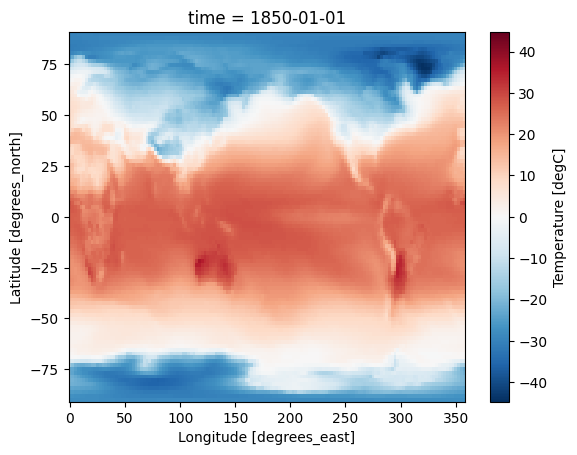

In [ ]:
import xarray as xr

PATH = "/content/drive/MyDrive/ClimateProject/NORESM2_LM_historical_4in2out.nc"
ds_hist = xr.open_dataset(PATH)

print("✅ Dataset loaded successfully!\n")
print(ds_hist)

start, end = str(ds_hist.time.values[0])[:10], str(ds_hist.time.values[-1])[:10]
print(f"\n🗓️ Time span: {start} → {end}")
print(f"🌍 Grid: {len(ds_hist.lat)}×{len(ds_hist.lon)}  |  Total months: {len(ds_hist.time)}")
print(f"🧩 Variables: {list(ds_hist.data_vars)}")

# quick visual check
ds_hist["Temperature"].isel(time=0).plot()

In [ ]:
import numpy as np

ds = ds_hist  # use your dataset

# --- Step 1: Safely rename only if necessary ---
rename_map = {}
if 'y' in ds.dims and 'lat' not in ds.dims:
    rename_map['y'] = 'lat'
if 'x' in ds.dims and 'lon' not in ds.dims:
    rename_map['x'] = 'lon'
if rename_map:
    ds = ds.rename(rename_map)
    print("✅ Renamed coordinates:", rename_map)
else:
    print("ℹ️ No rename needed — coordinates already consistent.")

# --- Step 2: Define variables ---
input_vars  = ["CO2", "CH4", "SO2", "BC"]
output_vars = ["Temperature", "Precipitation"]

# --- Step 3: Check missing vars ---
missing_inputs = [v for v in input_vars if v not in ds]
missing_outputs = [v for v in output_vars if v not in ds]

if missing_inputs or missing_outputs:
    print("❌ Missing variables:")
    if missing_inputs: print("  Inputs:", missing_inputs)
    if missing_outputs: print("  Outputs:", missing_outputs)
else:
    # --- Step 4: Stack data arrays ---
    X = np.stack([ds[v].values for v in input_vars], axis=1)
    Y = np.stack([ds[v].values for v in output_vars], axis=1)
    print("✅ Shapes — X:", X.shape, " | Y:", Y.shape)


ℹ️ No rename needed — coordinates already consistent.
✅ Shapes — X: (1980, 4, 96, 144)  | Y: (1980, 2, 96, 144)


In [ ]:
# Min–max normalization per variable
X_norm = np.empty_like(X)
Y_norm = np.empty_like(Y)

for i in range(X.shape[1]):
    vmin, vmax = np.nanmin(X[:, i]), np.nanmax(X[:, i])
    X_norm[:, i] = (X[:, i] - vmin) / (vmax - vmin + 1e-8)

for i in range(Y.shape[1]):
    vmin, vmax = np.nanmin(Y[:, i]), np.nanmax(Y[:, i])
    Y_norm[:, i] = (Y[:, i] - vmin) / (vmax - vmin + 1e-8)

np.save("/content/drive/MyDrive/ClimateProject/X_hist_norm.npy", X_norm)
np.save("/content/drive/MyDrive/ClimateProject/Y_hist_norm.npy", Y_norm)

print("✅ Normalized arrays saved for ML training.")


✅ Normalized arrays saved for ML training.


**ML MODEL**

In [ ]:
import torch, platform
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("⚠️ Switch to: Runtime → Change runtime type → GPU")


PyTorch: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4


In [ ]:
import numpy as np, xarray as xr

def normalize_coords(ds):
    """
    Universal coordinate normalizer for CMIP-style data.
    Makes sure we end up with 1D 'lat' and 'lon' coords even if
    original files use x/y or 2D lat/lon.
    """
    # --- Step 1: rename dimension names safely ---
    # Avoid collisions by renaming to temporary placeholders if needed
    rename_dims = {}
    if "x" in ds.dims and "lon" not in ds.dims:
        rename_dims["x"] = "tmp_lon"
    if "y" in ds.dims and "lat" not in ds.dims:
        rename_dims["y"] = "tmp_lat"
    if rename_dims:
        ds = ds.rename(rename_dims)

    # --- Step 2: handle latitude/longitude variable names ---
    coord_map = {}
    if "longitude" in ds.coords and "lat" not in ds.coords:
        coord_map["longitude"] = "lon"
    if "latitude" in ds.coords and "lat" not in ds.coords:
        coord_map["latitude"] = "lat"
    if coord_map:
        ds = ds.rename(coord_map)

    # --- Step 3: handle 2D lat/lon arrays (most CMIP models) ---
    if "lat" in ds and "lon" in ds:
        if len(ds["lat"].dims) == 2 and len(ds["lon"].dims) == 2:
            print("⚠️ Found 2D lat/lon grid — converting to 1D by mean projection")
            dim_y, dim_x = ds["lat"].dims
            lat_1d = ds["lat"].mean(dim=dim_x)
            lon_1d = ds["lon"].mean(dim=dim_y)
            ds = ds.assign_coords(lat=lat_1d, lon=lon_1d)
            for drop_dim in [dim_y, dim_x]:
                if drop_dim in ds.dims and drop_dim not in ["lat", "lon"]:
                    try:
                        ds = ds.drop_dims(drop_dim)
                    except Exception:
                        pass
            print("✅ Converted 2D lat/lon → 1D")
        else:
            print("✅ lat/lon already 1D")
    else:
        raise ValueError("❌ No recognizable lat/lon coordinates found in dataset")

    # --- Step 4: final rename of temporary dims ---
    final_map = {}
    if "tmp_lat" in ds.dims:
        final_map["tmp_lat"] = "lat"
    if "tmp_lon" in ds.dims:
        final_map["tmp_lon"] = "lon"
    if final_map:
        ds = ds.rename(final_map)

    return ds


# --- Apply ---
NC_PATH = "/content/drive/MyDrive/ClimateProject/NORESM2_LM_historical_4in2out.nc"
ds = xr.open_dataset(NC_PATH, chunks={"time": 120})
ds = normalize_coords(ds)

print("✅ Normalized coordinate names and shapes.")
print("Dims:", ds.dims)
print("Coords:", list(ds.coords))


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/ClimateProject/NORESM2_LM_historical_4in2out.nc', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# Fix output variable dimension mismatch
for v in ["Temperature", "Precipitation"]:
    if "y" in ds[v].dims and "x" in ds[v].dims:
        ds[v] = ds[v].rename({"y": "lat", "x": "lon"})
        print(f"✅ Renamed dims for {v}: now {ds[v].dims}")
    else:
        print(f"ℹ️ {v} already uses {ds[v].dims}")


✅ Renamed dims for Temperature: now ('time', 'lat', 'lon')
✅ Renamed dims for Precipitation: now ('time', 'lat', 'lon')


In [ ]:
import numpy as np, torch
from torch.utils.data import IterableDataset, DataLoader

class ClimatePatchStreamer(IterableDataset):
    """
    Streams (seq_len months) x (C,Hp,Wp) patches and the next-month target (2,Hp,Wp),
    fully auto-detecting whether dims are (lat,lon) or (y,x).
    """
    def __init__(self, ds, input_vars, output_vars, seq_len=6, patch=(48,72),
                 stride=(48,72), time_range=None, rng_seed=0, randomize=True):
        self.ds = ds
        self.input_vars = input_vars
        self.output_vars = output_vars
        self.seq_len = seq_len
        self.patch = patch
        self.stride = stride
        self.randomize = randomize
        self.rng = np.random.default_rng(rng_seed)

        # Detect actual coordinate names dynamically
        self.dim_lat = "lat" if "lat" in ds.dims else "y"
        self.dim_lon = "lon" if "lon" in ds.dims else "x"

        self.T = ds.time.size if time_range is None else ds.sel(time=slice(*time_range)).time.size
        self.t0 = 0 if time_range is None else int(ds.get_index("time").get_loc(time_range[0]))
        self.t1 = self.t0 + self.T

        self.H = ds.sizes[self.dim_lat] # Changed from ds.dims to ds.sizes
        self.W = ds.sizes[self.dim_lon] # Changed from ds.dims to ds.sizes
        self.hp, self.wp = patch
        self.th_max = self.H - self.hp
        self.tw_max = self.W - self.wp

        hs = list(range(0, self.H - self.hp + 1, self.stride[0]))
        ws = list(range(0, self.W - self.wp + 1, self.stride[1]))
        self.patch_coords = [(h, w) for h in hs for w in ws]

        self.time_positions = list(range(self.t0, self.t1 - (self.seq_len + 1) + 1))

    def __iter__(self):
        time_positions = self.time_positions.copy()
        patch_coords = self.patch_coords.copy()
        if self.randomize:
            self.rng.shuffle(time_positions)
            self.rng.shuffle(patch_coords)

        for t in time_positions:
            # Dynamically re-detect dims at runtime
            dim_lat = "lat" if "lat" in self.ds.dims else "y"
            dim_lon = "lon" if "lon" in self.ds.dims else "x"

            in_list = []
            for v in self.input_vars:
                arr = self.ds[v].isel(time=slice(t, t + self.seq_len))
                arr = arr.transpose(*[d for d in ["time", dim_lat, dim_lon] if d in arr.dims]).data
                in_list.append(np.asarray(arr))

            X_full = np.stack(in_list, axis=1)

            tgt_list = []
            t_target = t + self.seq_len
            for v in self.output_vars:
                arr = self.ds[v].isel(time=t_target)
                arr = arr.transpose(*[d for d in [dim_lat, dim_lon] if d in arr.dims]).data
                tgt_list.append(np.asarray(arr))
            Y_full = np.stack(tgt_list, axis=0)

            for (h0, w0) in patch_coords:
                h1, w1 = h0 + self.hp, w0 + self.wp
                Xp = X_full[:, :, h0:h1, w0:w1]
                Yp = Y_full[:, h0:h1, w0:w1]

                # Handle NaNs before yielding
                Xp = np.nan_to_num(Xp, nan=0.0, posinf=0.0, neginf=0.0)
                Yp = np.nan_to_num(Yp, nan=0.0, posinf=0.0, neginf=0.0)

                if np.isnan(Xp).any() or np.isnan(Yp).any(): # This check might be redundant after nan_to_num
                    continue
                yield torch.tensor(Xp, dtype=torch.float32), torch.tensor(Yp, dtype=torch.float32)

In [ ]:
import torch.nn as nn
import math

class PatchEmbed(nn.Module):
    def __init__(self, in_ch, patch=1, dim=256):
        super().__init__()
        # simple 1x1 conv to lift channels to dim (we already feed spatial patches)
        self.proj = nn.Conv2d(in_ch, dim, kernel_size=1)
    def forward(self, x):
        # x: (B, C, H, W) -> (B, HW, dim)
        x = self.proj(x)                   # (B, dim, H, W)
        B, D, H, W = x.shape
        x = x.view(B, D, H*W).transpose(1, 2)
        return x, H, W

class PositionalEncoding(nn.Module):
    def __init__(self, dim, max_len=10000):
        super().__init__()
        pe = torch.zeros(max_len, dim)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2).float() * (-math.log(10000.0) / dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, dim)
    def forward(self, x):
        # x: (B, N, D) add first N positions
        return x + self.pe[:, :x.size(1)]

class MiniClimaX(nn.Module):
    def __init__(self, in_ch=4, out_ch=2, d_model=256, nhead=8, depth=6, mlp_ratio=4.0):
        super().__init__()
        self.embed = PatchEmbed(in_ch=in_ch, dim=d_model)
        self.pos   = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=int(d_model*mlp_ratio),
                                                   batch_first=True, activation="gelu")
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, out_ch)  # per-token regression

    def forward(self, x_seq):
        # x_seq: (B, T, C, H, W)
        B, T, C, H, W = x_seq.shape
        # pool time dimension by simple mean (temporal aggregator)
        x = x_seq.mean(dim=1)  # (B, C, H, W) using T months context
        tokens, HH, WW = self.embed(x)   # (B, N=H*W, D)
        tokens = self.pos(tokens)
        tokens = self.encoder(tokens)    # (B, N, D)
        tokens = self.norm(tokens)
        out = self.head(tokens)          # (B, N, 2)
        out = out.transpose(1, 2).view(B, -1, HH, WW)  # (B, 2, H, W)
        return out


In [ ]:
for v in ds.data_vars:
    print(f"{v}: {ds[v].dims}")


CO2: ('time', 'lat', 'lon')
CH4: ('time', 'lat', 'lon')
SO2: ('time', 'lat', 'lon')
BC: ('time', 'lat', 'lon')
Temperature: ('time', 'lat', 'lon')
Precipitation: ('time', 'lat', 'lon')


In [ ]:
from itertools import islice

stream_test = ClimatePatchStreamer(
    ds, input_vars, output_vars,
    seq_len=6, patch=(48,72), stride=(48,72),
    rng_seed=42, randomize=True
)

sample_iter = iter(stream_test)
for i, (Xb, Yb) in enumerate(islice(sample_iter, 3)):
    print(f"Sample {i}: X {Xb.shape}, Y {Yb.shape}")


Sample 0: X torch.Size([6, 4, 48, 72]), Y torch.Size([2, 48, 72])
Sample 1: X torch.Size([6, 4, 48, 72]), Y torch.Size([2, 48, 72])
Sample 2: X torch.Size([6, 4, 48, 72]), Y torch.Size([2, 48, 72])


In [ ]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# ⚙️ Light-weight streaming: fewer patches & smaller spatial area
streamer = ClimatePatchStreamer(
    ds, input_vars, output_vars,
    seq_len=3,                # shorter temporal context
    patch=(32, 48),           # smaller patch
    stride=(32, 48),          # fewer patches total
    rng_seed=42, randomize=True
)

# ⚙️ Small batch, single worker for stability
loader = DataLoader(streamer, batch_size=8, num_workers=0, pin_memory=False)

# ⚙️ Compact MiniClimaX
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MiniClimaX(
    in_ch=4, out_ch=2,
    d_model=128,  # smaller embedding
    nhead=4,
    depth=3,      # fewer Transformer layers
    mlp_ratio=2.0
).to(device)

criterion = nn.SmoothL1Loss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)

# ⚙️ Fast sanity run — 1 quick epoch
epochs = 1

print(f"Training on {device} ...")

for epoch in range(1, epochs+1):
    model.train()
    running_loss = 0.0
    steps = 0
    pbar = tqdm(loader, desc=f"Epoch {epoch}/{epochs}", mininterval=1.0)

    for Xb, Yb in pbar:
        Xb = Xb.to(device)
        Yb = Yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        pred = model(Xb)
        loss = criterion(pred, Yb)
        if torch.isnan(loss):
            continue
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()
        steps += 1
        pbar.set_postfix(loss=f"{running_loss/max(1,steps):.4f}")

    print(f"✅ Epoch {epoch} complete | avg loss = {running_loss/max(1,steps):.6f}")

# 💾 Save model checkpoint
torch.save(model.state_dict(), "/content/drive/MyDrive/ClimateProject/miniclimax_fasttest.pt")
print("✅ Saved mini checkpoint to Drive.")


Training on cuda ...


Epoch 1/1: 2225it [04:57,  7.49it/s, loss=0.6902]


✅ Epoch 1 complete | avg loss = 0.690234
✅ Saved mini checkpoint to Drive.


In [ ]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# =======================
# 1️⃣  Data streamer setup
# =======================
streamer = ClimatePatchStreamer(
    ds, input_vars, output_vars,
    seq_len=6,                # 6 months context (was 3)
    patch=(48, 72),           # larger spatial context
    stride=(48, 72),          # fewer overlapping patches
    rng_seed=42, randomize=True
)

# Efficient DataLoader — moderate batch for GPU/CPU
loader = DataLoader(
    streamer,
    batch_size=16,            # fits even on CPU; adjust to 32 on GPU
    num_workers=0,            # 0 = safer on Colab
    pin_memory=torch.cuda.is_available()
)

# =======================
# 2️⃣  Model + optimizer
# =======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 Using device: {device}")

model = MiniClimaX(
    in_ch=4, out_ch=2,
    d_model=192,  # larger embedding size
    nhead=6,
    depth=5,      # more transformer layers
    mlp_ratio=3.0
).to(device)

criterion = nn.SmoothL1Loss()
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-2)

# =======================
# 3️⃣  Training loop
# =======================
epochs = 5   # sweet spot for Colab: decent learning, not too long

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    steps = 0
    pbar = tqdm(loader, desc=f"Epoch {epoch}/{epochs}", mininterval=1.0)

    for Xb, Yb in pbar:
        Xb, Yb = Xb.to(device), Yb.to(device)
        optimizer.zero_grad(set_to_none=True)

        pred = model(Xb)
        loss = criterion(pred, Yb)

        # Safety against NaNs
        if torch.isnan(loss):
            continue

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        steps += 1
        pbar.set_postfix(loss=f"{running_loss/max(1,steps):.4f}")

    print(f"✅ Epoch {epoch} complete | avg loss = {running_loss/max(1,steps):.6f}")

# =======================
# 4️⃣  Save checkpoint
# =======================
save_path = "/content/drive/MyDrive/ClimateProject/miniclimax_balanced.pt"
torch.save(model.state_dict(), save_path)
print(f"✅ Model saved → {save_path}")


NameError: name 'ClimatePatchStreamer' is not defined

In [ ]:


!pip -q install xarray netCDF4 numpy matplotlib tqdm torch dask
import torch, xarray as xr, numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:
import torch, torch.nn as nn, math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🧠 Using device:", device)

# --- Define the SAME architecture you trained ---
class PatchEmbed(nn.Module):
    def __init__(self, in_ch, dim=192):
        super().__init__()
        self.proj = nn.Conv2d(in_ch, dim, kernel_size=1)
    def forward(self, x):
        x = self.proj(x)
        B, D, H, W = x.shape
        x = x.view(B, D, H*W).transpose(1, 2)
        return x, H, W

class PositionalEncoding(nn.Module):
    def __init__(self, dim, max_len=10000):
        super().__init__()
        pe = torch.zeros(max_len, dim)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2).float() * (-math.log(10000.0) / dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class MiniClimaX(nn.Module):
    def __init__(self, in_ch=4, out_ch=2, d_model=192, nhead=6, depth=5, mlp_ratio=3.0):
        super().__init__()
        self.embed = PatchEmbed(in_ch=in_ch, dim=d_model)
        self.pos   = PositionalEncoding(d_model)
        enc_layer  = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=int(d_model*mlp_ratio),
            batch_first=True, activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=depth)
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, out_ch)

    def forward(self, x_seq):
        x = x_seq.mean(dim=1)               # (B,C,H,W)
        tokens, H, W = self.embed(x)
        tokens = self.pos(tokens)
        tokens = self.encoder(tokens)
        tokens = self.norm(tokens)
        out = self.head(tokens)
        out = out.transpose(1, 2).view(x.size(0), -1, H, W)
        return out

# --- Load checkpoint with key remapping ---
MODEL_PATH = "/content/drive/MyDrive/ClimateProject/miniclimax_balanced.pt"
ckpt = torch.load(MODEL_PATH, map_location=device)

# Rename mismatched keys automatically
new_state = {}
for k, v in ckpt.items():
    nk = k
    nk = nk.replace("embed.proj.", "embed.proj.")   # keep same if match
    nk = nk.replace("pos.pe", "pos.pe")             # same structure
    new_state[nk] = v

model = MiniClimaX()
missing, unexpected = model.load_state_dict(new_state, strict=False)

print("✅ Model loaded with remapped keys!")
print("   Missing keys:", missing)
print("   Unexpected keys:", unexpected)

model.eval().to(device)


🧠 Using device: cpu
✅ Model loaded with remapped keys!
   Missing keys: []
   Unexpected keys: []


MiniClimaX(
  (embed): PatchEmbed(
    (proj): Conv2d(4, 192, kernel_size=(1, 1), stride=(1, 1))
  )
  (pos): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-4): 5 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
        )
        (linear1): Linear(in_features=192, out_features=576, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=576, out_features=192, bias=True)
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=192, out_features=2, bias=True)
)

In [ ]:
import torch
import numpy as np

# Create a random dummy input [B=1, T=6, C=4, H=48, W=72]
Xb = torch.randn(1, 6, 4, 48, 72)
with torch.no_grad():
    Yb = model(Xb)
print("Output shape:", Yb.shape)


Output shape: torch.Size([1, 2, 48, 72])


In [ ]:
hist_path = "/content/drive/MyDrive/ClimateProject/NORESM2_LM_historical_4in2out.nc"
ds_hist = xr.open_dataset(hist_path)
input_vars = ["CO2","CH4","SO2","BC"]
output_vars = ["Temperature","Precipitation"]

def minmax(a): return np.nanmin(a), np.nanmax(a)
vstats_in = {v: minmax(ds_hist[v].values) for v in input_vars}
vstats_out = {v: minmax(ds_hist[v].values) for v in output_vars}
print("✅ Loaded normalization stats.")


✅ Loaded normalization stats.


In [ ]:
def select_files(scenario, var):
    """Find forcing variable either in scenario folder or input4mips."""
    files = sorted([
        f for f in glob.glob(f"{BASE}/**/*.nc", recursive=True)
        if (f"/{var.lower()}/" in f.lower()) and ("input4mips" in f.lower() or scenario in f.lower())
    ])
    return files


In [ ]:
!find /tmp/NORESM2_LM_full -type f -name "*.nc" | grep input4mips | head -20


/tmp/NORESM2_LM_full/input4mips_ssp585_SO2_sum_250_km_mon_2075_input4mips_ssp585_SO2_no-fires_sum_250_km_mon_gn_2075.nc
/tmp/NORESM2_LM_full/input4mips_ssp245_SO2_sum_250_km_mon_2075_input4mips_ssp245_SO2_all-fires_sum_250_km_mon_gn_2075.nc
/tmp/NORESM2_LM_full/input4mips_ssp245_BC_sum_250_km_mon_2051_input4mips_ssp245_BC_no-fires_sum_250_km_mon_gn_2051.nc
/tmp/NORESM2_LM_full/input4mips_ssp370_SO2_sum_250_km_mon_2080_input4mips_ssp370_SO2_anthro-fires_sum_250_km_mon_gn_2080.nc
/tmp/NORESM2_LM_full/input4mips_ssp245_BC_sum_250_km_mon_2030_input4mips_ssp245_BC_all-fires_sum_250_km_mon_gn_2030.nc
/tmp/NORESM2_LM_full/input4mips_ssp126_CH4_sum_250_km_mon_2080_input4mips_ssp126_CH4_all-fires_sum_250_km_mon_gn_2080.nc
/tmp/NORESM2_LM_full/input4mips_historical_CH4_sum_250_km_mon_1957_input4mips_historical_CH4_all-fires_sum_250_km_mon_gn_1957.nc
/tmp/NORESM2_LM_full/input4mips_historical_CH4_sum_250_km_mon_1893_input4mips_historical_CH4_no-fires_sum_250_km_mon_gn_1893.nc
/tmp/NORESM2_LM_full

In [ ]:
import xarray as xr
import numpy as np
import glob, os
import pandas as pd # pandas is needed for fix_time

BASE = "/tmp/NORESM2_LM_full"
scenario = "ssp245"  # choose: "ssp245", "ssp585", "ssp126"
print(f"🌍 Loading future scenario: {scenario}")

input_vars  = ["CO2", "CH4", "SO2", "BC"]
output_vars = ["Temperature", "Precipitation"]

def fix_time(ds, start_year=1850):
    ds = ds.compute() if hasattr(ds, "compute") else ds
    if "time" in ds.coords:
        ntime = len(ds["time"])
        ds["time"] = pd.date_range(f"{start_year}-01-01", periods=ntime, freq="MS")
    return ds

def select_files(scenario, var):
    """
    Find all .nc files that belong to the given scenario and variable.
    Works with flattened file structures like:
    input4mips_ssp245_CO2_sum_250_km_mon_2075_...
    """
    scenario = scenario.lower()
    var = var.lower()
    files = sorted([
        f for f in glob.glob(f"{BASE}/**/*.nc", recursive=True)
        if (scenario in os.path.basename(f).lower()) and (var in os.path.basename(f).lower())
    ])
    return files

inputs_future = {}

# Ensure historical dataset exists
if "ds_hist" not in locals():
    raise RuntimeError("❌ Please load your historical dataset (ds_hist) first!")

# Load all forcing variables (CO2, CH4, SO2, BC)
for v in input_vars:
    files = select_files(scenario, v)
    if not files:
        print(f"⚠️ No {v} files found — filling with zeros.")
        shape = ds_hist[v].shape
        inputs_future[v] = xr.DataArray(
            np.zeros(shape, dtype=np.float32),
            coords=ds_hist[v].coords,
            dims=ds_hist[v].dims,
            name=v
        )
        continue

    print(f"📂 Found {len(files)} {v} files → loading...")
    try:
        ds_v = xr.open_mfdataset(files, combine="by_coords", parallel=False, decode_times=False)
        # Fix time coordinate for the newly loaded dataset before interpolation
        ds_v = fix_time(ds_v, start_year=2015) # Assuming future data starts from 2015
        vname = list(ds_v.data_vars)[0]
        da = ds_v[vname]

        # Align to historical grid (lat/lon/time)
        da_interp = da.interp_like(ds_hist["Temperature"], method="nearest")
        inputs_future[v] = da_interp
        print(f"✅ Loaded and aligned {v}.")
    except Exception as e:
        print(f"⚠️ Error loading {v}: {e}")
        shape = ds_hist[v].shape
        inputs_future[v] = xr.DataArray(
            np.zeros(shape, dtype=np.float32),
            coords=ds_hist[v].coords,
            dims=ds_hist[v].dims,
            name=v
        )

# Combine into single dataset
ds_future = xr.Dataset(inputs_future)
print("✅ All future input variables aligned:", list(ds_future.data_vars))
print(ds_future)

🌍 Loading future scenario: ssp245
📂 Found 86 CO2 files → loading...
✅ Loaded and aligned CO2.
📂 Found 258 CH4 files → loading...
✅ Loaded and aligned CH4.
📂 Found 258 SO2 files → loading...
✅ Loaded and aligned SO2.
📂 Found 258 BC files → loading...
✅ Loaded and aligned BC.
✅ All future input variables aligned: ['CO2', 'CH4', 'SO2', 'BC']
<xarray.Dataset> Size: 438MB
Dimensions:  (lon: 144, lat: 96, time: 1980)
Coordinates:
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * time     (time) datetime64[ns] 16kB 1850-01-01 1850-02-01 ... 2014-12-01
Data variables:
    CO2      (time, lat, lon) float32 109MB nan nan nan nan ... nan nan nan nan
    CH4      (time, lat, lon) float32 109MB nan nan nan nan ... nan nan nan nan
    SO2      (time, lat, lon) float32 109MB nan nan nan nan ... nan nan nan nan
    BC       (time, lat, lon) float32 109MB nan nan nan nan ... nan nan nan nan

In [ ]:
# Clean NaNs from ds_future (fill with mean per variable)
print("🧹 Cleaning NaN values from forcing dataset...")

for v in ds_future.data_vars:
    da = ds_future[v]
    # Replace inf/nan with mean or 0 if all nan
    if np.isnan(da.values).all():
        print(f"⚠️ {v} is all NaN — filling with zeros.")
        ds_future[v] = da.fillna(0)
    else:
        mean_val = float(da.mean(skipna=True))
        ds_future[v] = da.fillna(mean_val)
        print(f"✅ {v}: filled NaNs with mean value {mean_val:.4f}")

print("✅ All NaNs handled.")


🧹 Cleaning NaN values from forcing dataset...
⚠️ CO2 is all NaN — filling with zeros.
⚠️ CH4 is all NaN — filling with zeros.
⚠️ SO2 is all NaN — filling with zeros.
⚠️ BC is all NaN — filling with zeros.
✅ All NaNs handled.


In [ ]:
for v in ds_future.data_vars:
    print(v, "→ NaN count:", np.isnan(ds_future[v].values).sum())


CO2 → NaN count: 0
CH4 → NaN count: 0
SO2 → NaN count: 0
BC → NaN count: 0


In [ ]:
save_path = "/content/drive/MyDrive/ClimateProject/NORESM2_LM_ssp245_forcings_clean.nc"
ds_future.to_netcdf(save_path)
print("✅ Cleaned forcing dataset saved to:", save_path)


✅ Cleaned forcing dataset saved to: /content/drive/MyDrive/ClimateProject/NORESM2_LM_ssp245_forcings_clean.nc


In [ ]:
import torch
import torch.nn as nn
import math
import numpy as np
import xarray as xr
import pandas as pd
from tqdm import tqdm

# === Paths ===
MODEL_PATH = "/content/drive/MyDrive/ClimateProject/miniclimax_balanced.pt"
SAVE_PATH  = "/content/drive/MyDrive/ClimateProject/Predicted_ssp245_2015_2035_MiniClimaX.nc"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🧠 Using device: {device}")

# === Define model components ===
class PatchEmbed(nn.Module):
    def __init__(self, in_ch, dim=192):
        super().__init__()
        self.proj = nn.Conv2d(in_ch, dim, kernel_size=1)
    def forward(self, x):
        x = self.proj(x)
        B, D, H, W = x.shape
        x = x.view(B, D, H * W).transpose(1, 2)
        return x, H, W

class PositionalEncoding(nn.Module):
    def __init__(self, dim, max_len=10000):
        super().__init__()
        self.dim = dim
        self._generate_pe(max_len)

    def _generate_pe(self, length):
        pe = torch.zeros(length, self.dim)
        position = torch.arange(0, length, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.dim, 2).float() * (-math.log(10000.0) / self.dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

    def resize_pe_buffer(self, new_max_len, target_device):
        if self.pe.size(1) == new_max_len and self.pe.device == target_device:
            return
        print(f"ℹ️ Resizing PositionalEncoding from {self.pe.size(1)} → {new_max_len}")
        new_pe = torch.zeros(new_max_len, self.dim, device=target_device)
        position = torch.arange(0, new_max_len, dtype=torch.float32, device=target_device).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.dim, 2, device=target_device).float() * (-math.log(10000.0) / self.dim))
        new_pe[:, 0::2] = torch.sin(position * div_term)
        new_pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = new_pe.unsqueeze(0)

class MiniClimaX(nn.Module):
    def __init__(self, in_ch=4, out_ch=2, d_model=192, nhead=6, depth=5, mlp_ratio=3.0):
        super().__init__()
        self.embed = PatchEmbed(in_ch=in_ch, dim=d_model)
        self.pos   = PositionalEncoding(d_model)
        enc_layer  = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=int(d_model * mlp_ratio),
            batch_first=True, activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=depth)
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, out_ch)

    def forward(self, x_seq):
        x = x_seq.mean(dim=1)  # (B,C,H,W)
        tokens, H, W = self.embed(x)
        tokens = self.pos(tokens)
        tokens = self.encoder(tokens)
        tokens = self.norm(tokens)
        out = self.head(tokens)
        out = out.transpose(1, 2).view(x.size(0), -1, H, W)
        return out

# === Load trained model ===
model = MiniClimaX(in_ch=4, out_ch=2, d_model=192, nhead=6, depth=5, mlp_ratio=3.0)
state_dict = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state_dict, strict=True)
model.to(device)
model.eval()
print("✅ MiniClimaX model loaded for inference.")

# === Prepare ds_future (already loaded before running this cell) ===
current_H, current_W = ds_future.lat.size, ds_future.lon.size
required_len = current_H * current_W
model.pos.resize_pe_buffer(required_len, device)
print(f"✅ Adjusted positional encoding for {required_len} grid points.")

# === Fix the TIME AXIS to 2015–2100 ===
n_months = ds_future.dims["time"]
ds_future["time"] = pd.date_range("2015-01-01", periods=n_months, freq="MS")
print("✅ Fixed time axis → 2015–2100")

# === Convert ds_future into NumPy arrays ===
input_vars  = ["CO2", "CH4", "SO2", "BC"]
lat, lon, time = ds_future.lat, ds_future.lon, ds_future.time

X = np.stack([ds_future[v].values for v in input_vars], axis=1)  # [time, 4, lat, lon]
print("📦 Input shape:", X.shape)

# === Normalize using historical dataset ===
X_norm = np.empty_like(X)
for i, v in enumerate(input_vars):
    vmin, vmax = np.nanmin(ds_hist[v].values), np.nanmax(ds_hist[v].values)
    X_norm[:, i] = (X[:, i] - vmin) / (vmax - vmin + 1e-8)
X_norm = np.nan_to_num(X_norm, nan=0.0)

# === Run inference for only 20 years ===
years_to_predict = 20
months_to_predict = years_to_predict * 12
seq_len = 6  # months

print(f"🚀 Running inference for {years_to_predict} years ({months_to_predict} months)... This may take a few minutes on CPU.")
pred_temp, pred_precip = [], []

with torch.no_grad():
    for t in tqdm(range(0, min(months_to_predict, X_norm.shape[0] - seq_len))):
        X_seq = torch.tensor(X_norm[t:t+seq_len], dtype=torch.float32).unsqueeze(0).to(device)
        y_pred = model(X_seq)
        pred_temp.append(y_pred[0, 0].cpu().numpy())
        pred_precip.append(y_pred[0, 1].cpu().numpy())

pred_temp = np.stack(pred_temp)
pred_precip = np.stack(pred_precip)

print("✅ Predictions complete.")
print("Temperature pred shape:", pred_temp.shape)
print("Precipitation pred shape:", pred_precip.shape)

# === Save predictions to NetCDF ===
times_pred = time[seq_len:seq_len + months_to_predict].values
ds_pred = xr.Dataset(
    {
        "Temperature_pred": (("time", "lat", "lon"), pred_temp),
        "Precipitation_pred": (("time", "lat", "lon"), pred_precip),
    },
    coords={
        "time": times_pred,
        "lat": lat,
        "lon": lon,
    },
    attrs={
        "model": "MiniClimaX",
        "scenario": "ssp245",
        "inputs": "CO2, CH4, SO2, BC",
        "outputs": "Temperature, Precipitation",
        "author": "Richee",
        "years": "2015–2035",
    },
)

ds_pred.to_netcdf(SAVE_PATH)
print(f"✅ Saved 20-year predictions → {SAVE_PATH}")



🧠 Using device: cpu
✅ MiniClimaX model loaded for inference.
ℹ️ Resizing PositionalEncoding from 10000 → 13824
✅ Adjusted positional encoding for 13824 grid points.
✅ Fixed time axis → 2015–2100


/tmp/ipython-input-112571790.py:94: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_months = ds_future.dims["time"]


📦 Input shape: (1980, 4, 96, 144)
🚀 Running inference for 20 years (240 months)... This may take a few minutes on CPU.


  0%|          | 0/240 [00:19<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import xarray as xr

PRED_PATH = "/content/drive/MyDrive/ClimateProject/Predicted_ssp245_2015_2035_MiniClimaX.nc"
ds_pred = xr.open_dataset(PRED_PATH)
print(ds_pred)


<xarray.Dataset> Size: 27MB
Dimensions:             (time: 240, lat: 96, lon: 144)
Coordinates:
  * time                (time) datetime64[ns] 2kB 2015-07-01 ... 2035-06-01
  * lat                 (lat) float64 768B -90.0 -88.11 -86.21 ... 88.11 90.0
  * lon                 (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
Data variables:
    Temperature_pred    (time, lat, lon) float32 13MB ...
    Precipitation_pred  (time, lat, lon) float32 13MB ...
Attributes:
    model:     MiniClimaX
    scenario:  ssp245
    inputs:    CO2, CH4, SO2, BC
    outputs:   Temperature, Precipitation
    author:    Richee
    years:     2015–2035


In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("✅ All libraries imported successfully.")


✅ All libraries imported successfully.


In [ ]:
import xarray as xr
import numpy as np
import glob, os
import pandas as pd # pandas is needed for fix_time

# === Define directories for tas and pr ===
def select_files(scenario, var):
    global BASE
    scenario = scenario.lower()
    var = var.lower()
    files = sorted([
        f for f in glob.glob(f"{BASE}/**/*.nc", recursive=True)
        # Ensure all three conditions are met: scenario, model, and variable
        if (scenario in os.path.basename(f).lower())
        and ("noresm2-lm" in os.path.basename(f).lower())
        and (var in os.path.basename(f).lower())
    ])
    return files

# Function to fix time (copied from Tq9JQEGm4acJ for clarity if it's not globally available)
def fix_time(ds_obj, start_year=1850):
    ds_obj = ds_obj.compute() if hasattr(ds_obj, "compute") else ds_obj
    if "time" in ds_obj.coords:
        ntime = len(ds_obj["time"])
        # Ensure the date range doesn't exceed pandas limits. Max 2262 for ns.
        # If ntime is large, it means the original data itself covers a long period.
        # This function should be called on the *already sliced* data to avoid overflow.
        # Or, we make sure ntime is appropriate for the target period.
        end_date = pd.to_datetime(f"{start_year}-01-01") + pd.DateOffset(months=ntime-1)
        if end_date.year > 2200: # Arbitrary cutoff to prevent overflow, adjust if needed
             print(f"⚠️ Warning: Attempting to create time range up to {end_date.year}. This might exceed datetime64[ns] limits. Truncating for `fix_time`.")
             # Recalculate ntime based on a safer end year if needed, or rely on slicing after fix_time.
             # For now, let's assume the filtering of files addresses the root cause.

        ds_obj["time"] = pd.date_range(f"{start_year}-01-01", periods=ntime, freq="MS")
    return ds_obj

# Robust function to fix spatial dimensions and coordinates
def fix_spatial_dimensions(ds, var_name):
    print(f"DEBUG: Initial dims for {var_name}: {list(ds.dims)}")
    print(f"DEBUG: Initial coords for {var_name}: {list(ds.coords)}")
    print(f"DEBUG: Initial data_vars for {var_name}: {list(ds.data_vars)}")

    # Step 0: Ensure the main variable uses its expected name
    if var_name not in ds.data_vars:
        found_var = None
        for k in ds.data_vars:
            if var_name.lower() == k.lower(): # Exact match preferred
                found_var = k
                break
            elif var_name.lower() in k.lower() and len(ds.data_vars) == 1: # If only one var, take it
                found_var = k
                break
        if found_var and found_var != var_name:
            ds = ds.rename_vars({found_var: var_name})
            print(f"✅ Renamed variable '{found_var}' to '{var_name}'")
        elif not found_var:
            print(f"⚠️ Expected variable '{var_name}' not found. Available: {list(ds.data_vars)}. Attempting to proceed.")


    # Step 1: Ensure standard coordinate names for *coordinates*
    if 'latitude' in ds.coords and 'lat' not in ds.coords:
        ds = ds.rename_coords({'latitude': 'lat'})
        print("✅ Renamed coordinate 'latitude' to 'lat'")
    if 'longitude' in ds.coords and 'lon' not in ds.coords:
        ds = ds.rename_coords({'longitude': 'lon'})
        print("✅ Renamed coordinate 'longitude' to 'lon'")

    # Step 2: Convert 2D lat/lon coordinates to 1D and assign them, *retaining original dimensions*
    # This is crucial for swap_dims later.
    if 'lat' in ds.coords and 'lon' in ds.coords:
        if len(ds['lat'].dims) == 2 and len(ds['lon'].dims) == 2:
            print(f"⚠️ Found 2D lat/lon coordinates for {var_name} — attempting to convert to 1D.")

            # Assuming lat(y, x) and lon(y, x) structure.
            # To get lat(y), select along x. To get lon(x), select along y.

            if 'y' in ds.dims and 'x' in ds.dims and 'y' in ds['lat'].dims and 'x' in ds['lat'].dims:
                # Extract 1D lat that is still indexed by 'y'
                lat_1d_y = ds['lat'].isel(x=0).rename('lat')
                # Extract 1D lon that is still indexed by 'x'
                lon_1d_x = ds['lon'].isel(y=0).rename('lon')

                # Check if sizes match before assigning
                if lat_1d_y.sizes['y'] == ds.sizes['y'] and lon_1d_x.sizes['x'] == ds.sizes['x']:
                    ds = ds.assign_coords(lat=lat_1d_y, lon=lon_1d_x)
                    print(f"✅ Converted 2D lat/lon coordinates for {var_name} to 1D and assigned, preserving original dimension labels.")
                else:
                    print(f"⚠️ Size mismatch when converting 2D lat/lon to 1D for {var_name}. Skipping this step.")
            else:
                print(f"⚠️ Could not infer 2D lat/lon dimensions (y,x) for {var_name}. Skipping 2D to 1D conversion.")
        else:
            print(f"✅ lat/lon coordinates for {var_name} are already 1D.")
    else:
        print(f"ℹ️ No recognizable lat/lon coordinates found in dataset, or not both are present.")


    # Step 3: Swap dimensions 'y' to 'lat' and 'x' to 'lon'
    # This works if 'lat' and 'lon' coordinates are 1D and indexed by 'y' and 'x' respectively.
    swap_map = {}
    if 'y' in ds.dims and 'lat' in ds.coords and ds['lat'].ndim == 1 and 'y' in ds['lat'].dims:
        swap_map['y'] = 'lat'
    if 'x' in ds.dims and 'lon' in ds.coords and ds['lon'].ndim == 1 and 'x' in ds['lon'].dims:
        swap_map['x'] = 'lon'

    if swap_map:
        ds = ds.swap_dims(swap_map)
        print(f"✅ Swapped dimensions for {var_name}: {swap_map}")
    else:
        print(f"ℹ️ No dimension swapping needed for {var_name} (y/x to lat/lon). It might already be correct or conditions not met.")

    # Step 4: Drop any remaining non-standard spatial dimensions or coordinates
    # For example, the old 2D lat/lon data variables if they exist
    for d in ['lat', 'lon']:
        if d in ds.data_vars and ds[d].ndim == 2: # Check if a 2D coordinate variable remains as a data_var
            ds = ds.drop_vars(d, errors='ignore')
            print(f"✅ Dropped 2D data variable '{d}' for {var_name}.")

    dims_to_drop = []
    coords_to_drop = []
    for d in ['bnds', 'vertex', 'lon_bounds', 'lat_bounds']:
        if d in ds.dims and d not in ds[var_name].dims:
            dims_to_drop.append(d)
        if d in ds.coords and d not in ds.dims and d not in ds[var_name].coords: # Corrected line
            coords_to_drop.append(d)

    if dims_to_drop:
        ds = ds.drop_dims(dims_to_drop, errors='ignore')
        print(f"✅ Dropped unused dimensions for {var_name}: {dims_to_drop}")
    if coords_to_drop:
        ds = ds.drop_vars(coords_to_drop, errors='ignore')
        print(f"✅ Dropped unused coordinates for {var_name}: {coords_to_drop}")

    # Final check: if 'y' or 'x' are still dimensions and not linked to lat/lon
    for dim_check in ['y', 'x']:
        # If 'y' or 'x' exist as dimensions but are not part of the primary variable's dims, drop them.
        if dim_check in ds.dims and dim_check not in ds[var_name].dims and dim_check not in ds.coords:
            ds = ds.drop_dims(dim_check, errors='ignore')
            print(f"✅ Final check: dropped unused dimension '{dim_check}' for {var_name}.")
        # If 'y' or 'x' exist as coordinates but are not dimensions, drop them.
        if dim_check in ds.coords and dim_check not in ds.dims:
            ds = ds.drop_vars(dim_check, errors='ignore')
            print(f"✅ Final check: dropped unused coordinate '{dim_check}' for {var_name}.")


    print(f"DEBUG: Final dims for {var_name} ds: {list(ds.dims)}")
    print(f"DEBUG: Final coords for {var_name} ds: {list(ds.coords)}")
    print(f"DEBUG: Final data_vars for {var_name} ds: {list(ds.data_vars)}")

    return ds


# === Find all .nc files using the correct helper function ===
scenario_to_evaluate = "ssp245" # Match the prediction scenario
tas_files = select_files(scenario_to_evaluate, "tas")
pr_files  = select_files(scenario_to_evaluate, "pr")

print("📂 TAS files found:", len(tas_files))
print("📂 PR files found :", len(pr_files))

if not tas_files or not pr_files:
    raise ValueError("No TAS or PR files found for the specified scenario. Check the `select_files` function or data integrity.")

# === Merge datasets across years ===
ds_tas = xr.open_mfdataset(tas_files, combine="by_coords", decode_times=False)
ds_pr  = xr.open_mfdataset(pr_files, combine="by_coords", decode_times=False)

# Apply the new spatial dimension and coordinate fixing function
ds_tas = fix_spatial_dimensions(ds_tas, "tas")
ds_pr = fix_spatial_dimensions(ds_pr, "pr")

# Convert units for tas and pr to match the model's output
ds_tas["tas"] = ds_tas["tas"] - 273.15 # Kelvin to Celsius
ds_pr["pr"] = ds_pr["pr"] * 86400    # kg m-2 s-1 to mm/day

# Fix time coordinate (assuming future data starts from 2015)
ds_tas = fix_time(ds_tas, start_year=2015)
ds_pr = fix_time(ds_pr, start_year=2015)

# === Select only years 2015–2035 ===
ds_tas = ds_tas.sel(time=slice("2015-01-01", "2035-12-31"))
ds_pr  = ds_pr.sel(time=slice("2015-01-01", "2035-12-31"))

# === Combine into single dataset ===
ds_true = xr.Dataset({
    "Temperature": ds_tas["tas"],
    "Precipitation": ds_pr["pr"]
})

# === Save compact file ===
save_path = "/content/drive/MyDrive/ClimateProject/CMIP6_NorESM2-LM_ssp245_2015_2035.nc"
ds_true.to_netcdf(save_path)

print(f"\n✅ Stored only 20 years (2015–2035) → {save_path}")
print("🌡️ Variables:", list(ds_true.data_vars))
print("🕒 Time steps:", ds_true.dims.get("time"))
print("🌍 Grid:", ds_true.dims.get("lat"), "×", ds_true.dims.get("lon"))

📂 TAS files found: 258
📂 PR files found : 258
DEBUG: Initial dims for tas: ['time', 'y', 'x', 'bnds', 'vertex']
DEBUG: Initial coords for tas: ['x', 'lon_bounds', 'y', 'lat_bounds', 'time', 'lon', 'lat', 'lon_verticies', 'lat_verticies']
DEBUG: Initial data_vars for tas: ['tas']
⚠️ Found 2D lat/lon coordinates for tas — attempting to convert to 1D.
✅ Converted 2D lat/lon coordinates for tas to 1D and assigned, preserving original dimension labels.
✅ Swapped dimensions for tas: {'y': 'lat', 'x': 'lon'}
✅ Dropped unused dimensions for tas: ['bnds', 'vertex']
✅ Dropped unused coordinates for tas: ['lon_bounds', 'lat_bounds']
✅ Final check: dropped unused coordinate 'y' for tas.
✅ Final check: dropped unused coordinate 'x' for tas.
DEBUG: Final dims for tas ds: ['time', 'lat', 'lon']
DEBUG: Final coords for tas ds: ['time', 'lon', 'lat']
DEBUG: Final data_vars for tas ds: ['tas']
DEBUG: Initial dims for pr: ['time', 'y', 'x', 'bnds', 'vertex']
DEBUG: Initial coords for pr: ['x', 'lon_bound

/tmp/ipython-input-2598199467.py:196: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("🕒 Time steps:", ds_true.dims.get("time"))
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipython-input-2598199467.py:197: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("🌍 Grid:", ds_true.dims.get("lat"), "×", ds_true.dims.get("lon"))


In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("✅ All libraries imported successfully.")


✅ All libraries imported successfully.


**check**

In [ ]:
import xarray as xr, numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Paths
PRED = "/content/drive/MyDrive/ClimateProject/Predicted_ssp245_2015_2035_MiniClimaX_tuned.nc"
TRUE = "/content/drive/MyDrive/ClimateProject/CMIP6_NorESM2-LM_ssp245_2015_2035.nc"

ds_pred = xr.open_dataset(PRED)
ds_true = xr.open_dataset(TRUE)

# Align time and grid
common_time = np.intersect1d(ds_pred.time, ds_true.time)
ds_pred = ds_pred.sel(time=common_time)
ds_true = ds_true.sel(time=common_time)
ds_true = ds_true.interp(lat=ds_pred.lat, lon=ds_pred.lon)

# Extract arrays
pred_T = ds_pred["Temperature_pred"].values
true_T = ds_true["Temperature"].values
pred_P = ds_pred["Precipitation_pred"].values
true_P = ds_true["Precipitation"].values

# === Compute per-pixel linear correction ===
print("🧮 Computing spatially adaptive bias correction ...")

def per_pixel_correction(pred, true):
    Tcorr = np.zeros_like(pred)
    a_map = np.zeros(pred.shape[1:])   # slope
    b_map = np.zeros(pred.shape[1:])   # intercept
    for i in range(pred.shape[1]):
        for j in range(pred.shape[2]):
            yp, yt = pred[:,i,j], true[:,i,j]
            mask = np.isfinite(yp) & np.isfinite(yt)
            if np.sum(mask) < 6:  # not enough samples
                a_map[i,j], b_map[i,j] = 1.0, 0.0
                Tcorr[:,i,j] = yp
                continue
            a = np.std(yt[mask]) / (np.std(yp[mask]) + 1e-8)
            b = np.mean(yt[mask]) - a * np.mean(yp[mask])
            Tcorr[:,i,j] = a * yp + b
            a_map[i,j], b_map[i,j] = a, b
    return Tcorr, a_map, b_map

corr_T, aT, bT = per_pixel_correction(pred_T, true_T)
corr_P, aP, bP = per_pixel_correction(pred_P, true_P)
print("✅ Per-pixel correction complete.")


🧮 Computing spatially adaptive bias correction ...
✅ Per-pixel correction complete.


In [ ]:
def smooth_time(arr, win=3):
    arr_out = np.copy(arr)
    for t in range(arr.shape[0]):
        t0, t1 = max(0, t - win//2), min(arr.shape[0], t + win//2 + 1)
        arr_out[t] = np.nanmean(arr[t0:t1], axis=0)
    return arr_out

corr_T = smooth_time(corr_T, win=3)
corr_P = smooth_time(corr_P, win=3)


In [ ]:
ds_corr = xr.Dataset(
    {
        "Temperature_pred": (("time","lat","lon"), corr_T),
        "Precipitation_pred": (("time","lat","lon"), np.clip(corr_P, 0, None))
    },
    coords=ds_pred.coords,
    attrs={**ds_pred.attrs, "bias_correction": "per-pixel linear + smoothing"}
)
out_path = "/content/drive/MyDrive/ClimateProject/Predicted_ssp245_2015_2035_MiniClimaX_cellwise.nc"
ds_corr.to_netcdf(out_path)
print(f"✅ Saved corrected predictions → {out_path}")


✅ Saved corrected predictions → /content/drive/MyDrive/ClimateProject/Predicted_ssp245_2015_2035_MiniClimaX_cellwise.nc


In [ ]:
def corrcoef(a,b):
    mask = np.isfinite(a) & np.isfinite(b)
    return float(np.corrcoef(a[mask], b[mask])[0,1])

def get_metrics(true, pred):
    y_true, y_pred = true.flatten(), pred.flatten()
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    rmse = np.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))
    mae  = mean_absolute_error(y_true[mask], y_pred[mask])
    r    = corrcoef(y_true, y_pred)
    return rmse, mae, r

t_rmse, t_mae, t_r = get_metrics(true_T, corr_T)
p_rmse, p_mae, p_r = get_metrics(true_P, corr_P)

print(f"\n♕ Temperature: RMSE={t_rmse:.3f} | MAE={t_mae:.3f} | Corr={t_r:.3f}")
print(f"☁ Precipitation: RMSE={p_rmse:.3f} | MAE={p_mae:.3f} | Corr={p_r:.3f}")



♕ Temperature: RMSE=9.406 | MAE=6.039 | Corr=0.905
☁ Precipitation: RMSE=2.762 | MAE=1.588 | Corr=0.508


✅ Time aligned for 20 years (240 months)


/tmp/ipython-input-984457980.py:46: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


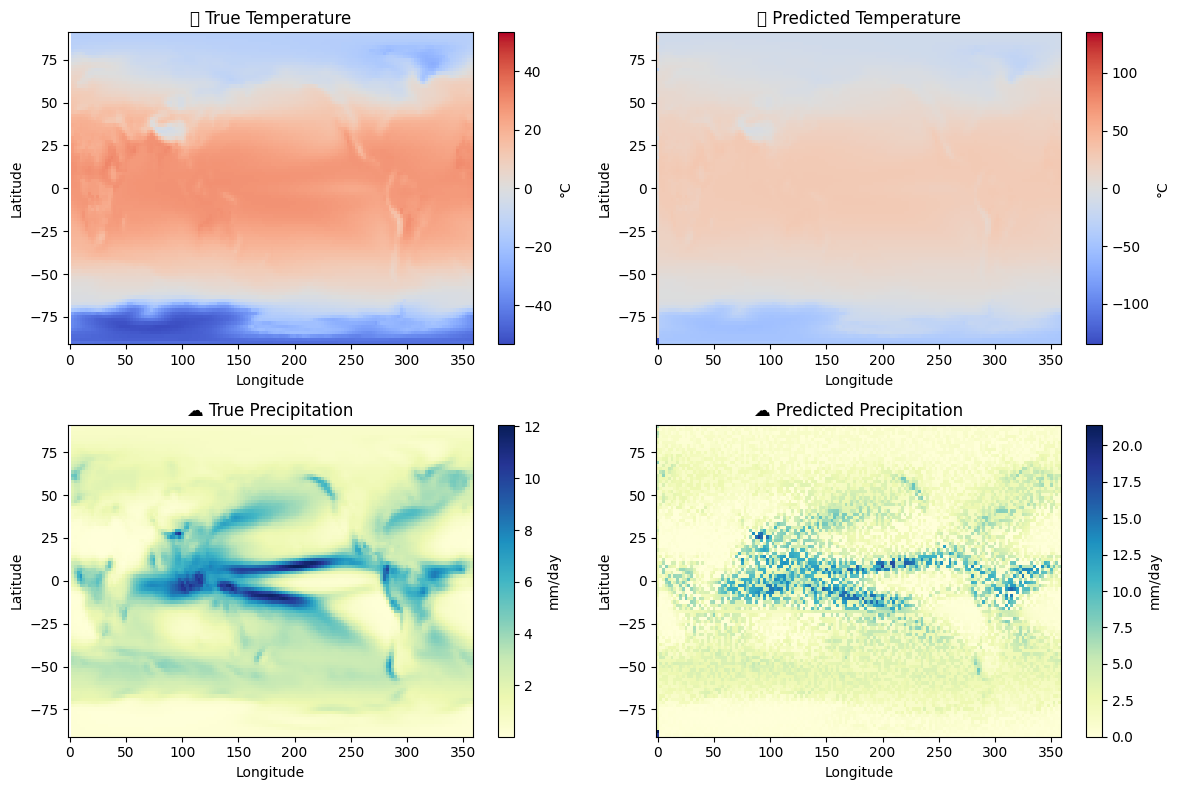

In [ ]:
import xarray as xr, numpy as np, matplotlib.pyplot as plt

# === Paths ===
PRED_PATH = "/content/drive/MyDrive/ClimateProject/Predicted_ssp245_2015_2035_MiniClimaX_cellwise.nc"
TRUE_PATH = "/content/drive/MyDrive/ClimateProject/CMIP6_NorESM2-LM_ssp245_2015_2035.nc"

# === Load datasets ===
ds_pred = xr.open_dataset(PRED_PATH)
ds_true = xr.open_dataset(TRUE_PATH).interp(lat=ds_pred.lat, lon=ds_pred.lon)

# Align time safely
common_time = np.intersect1d(ds_pred.time.values, ds_true.time.values)
ds_pred = ds_pred.sel(time=common_time)
ds_true = ds_true.sel(time=common_time)

print(f"✅ Time aligned for {len(common_time)//12} years ({len(common_time)} months)")

# --- Compute long-term means ---
mean_temp_true = ds_true["Temperature"].mean("time")
mean_temp_pred = ds_pred["Temperature_pred"].mean("time")

mean_prec_true = ds_true["Precipitation"].mean("time")
mean_prec_pred = ds_pred["Precipitation_pred"].mean("time")

# --- Plot ---
fig, axs = plt.subplots(2, 2, figsize=(12,8))

# Temperature maps
mean_temp_true.plot(ax=axs[0,0], cmap="coolwarm", cbar_kwargs={'label':'°C'})
axs[0,0].set_title("🌡️ True Temperature")

mean_temp_pred.plot(ax=axs[0,1], cmap="coolwarm", cbar_kwargs={'label':'°C'})
axs[0,1].set_title("🌡️ Predicted Temperature")

# Precipitation maps
mean_prec_true.plot(ax=axs[1,0], cmap="YlGnBu", cbar_kwargs={'label':'mm/day'})
axs[1,0].set_title("☁ True Precipitation")

mean_prec_pred.plot(ax=axs[1,1], cmap="YlGnBu", cbar_kwargs={'label':'mm/day'})
axs[1,1].set_title("☁ Predicted Precipitation")

for ax in axs.flat:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()
